In [3]:
# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
import xgboost as xgb
from sklearn.metrics import roc_auc_score, recall_score, precision_recall_curve, brier_score_loss
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')
RND=42


In [2]:
!pip install shap

   ---------------------------------------- 0.0/549.3 kB ? eta -:--:--
   ---------------------------------------- 549.3/549.3 kB 6.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
   ---- ----------------------------------- 1.6/15.6 MB 9.3 MB/s eta 0:00:02
   -------- ------------------------------- 3.1/15.6 MB 7.7 MB/s eta 0:00:02
   ----------- ---------------------------- 4.5/15.6 MB 7.3 MB/s eta 0:00:02
   ------------- -------------------------- 5.2/15.6 MB 6.5 MB/s eta 0:00:02
   ------------- -------------------------- 5.2/15.6 MB 6.5 MB/s eta 0:00:02
   -------------- ------------------------- 5.8/15.6 MB 4.6 MB/s eta 0:00:03
   ---------------- ----------------------- 6.3/15.6 MB 4.5 MB/s eta 0:00:03
   -------------------- ------------------- 7.9/15.6 MB 4.6 MB/s eta 0:00:02
   ----------------------- ---------------- 9.2/15.6 MB 4.9 MB/s eta 0:00:02
   -------------------------- ------------- 10.5/15.6 MB 5.1 MB/s eta 0:00:02
   -----

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.0.2 which is incompatible.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.0.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.0.2 which is incompatible.
tensorflow-intel 2.17.1 requires numpy<2.0.0,>=1.26.0; python_version >= "3.12", but you have numpy 2.0.2 which is incompatible.


In [4]:
# load the data
df = pd.read_csv("data.csv")

In [6]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,0,145,233,1,2,150,0,2.3,2,0,2,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,1,1
2,67,1,3,120,229,0,2,129,1,2.6,1,2,3,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,1,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,1,0


In [7]:
df.shape

(303, 14)

In [26]:
df.isnull().sum()

age              0
sex              0
cp               0
trestbps         0
chol             0
fbs              0
restecg          0
thalach          0
exang            0
oldpeak          0
slope            0
ca               0
thal             0
target           0
chol_bp_index    0
age_sq           0
pred_prob        0
risk_bucket      0
dtype: int64

In [8]:
# Target Mapping
if 'target' in df.columns:
    df['target'] = df['target'].apply(lambda x: 1 if x>0 else 0)
    target = 'target'
elif 'num' in df.columns:
    df['num'] = df['num'].apply(lambda x: 1 if x>0 else 0)
    target = 'num'
else:
    raise ValueError("Unexpected dataset columns; check CSV")


In [10]:
# identofy categories vs numeric 
num_cols = ['age','trestbps','chol','thalach','oldpeak']
cat_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']  # adjust to dataset
# ensure present
num_cols = [c for c in num_cols if c in df.columns]
cat_cols = [c for c in cat_cols if c in df.columns]

In [12]:
# Basic EDA 
print("Class balance:\n", df[target].value_counts())

Class balance:
 target
0    164
1    139
Name: count, dtype: int64


In [13]:
df[num_cols].describe()

,age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,131.689769,246.693069,149.607261,1.039604
std,9.038662,17.599748,51.776918,22.875003,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,48.000000,120.000000,211.000000,133.500000,0.000000
50%,56.000000,130.000000,241.000000,153.000000,0.800000
75%,61.000000,140.000000,275.000000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


In [14]:
# Feature Engineering 
df['chol_bp_index'] = df['chol'] * (df['trestbps'] / (df['trestbps'].median()+1))
df['age_sq'] = df['age'] ** 2

In [15]:
#preprocessing
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preproc = ColumnTransformer([
    ('num', num_transformer, num_cols + ['chol_bp_index','age_sq']),
    ('cat', cat_transformer, cat_cols)
])


In [17]:
# models: logistic (with interactions) and XGBoost
pipe_log = Pipeline([('pre', preproc), ('clf', LogisticRegression(max_iter=1000, random_state=RND))])
pipe_xgb = Pipeline([('pre', preproc), ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RND))])

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)

for name, pipe in [('Logistic', pipe_log), ('XGBoost', pipe_xgb)]:
    cur = cross_validate(pipe, df.drop(columns=[target]), df[target].values, cv=skf, scoring=['roc_auc','recall'], n_jobs=1)
    print(name, "ROC AUC:", np.mean(cur['test_roc_auc']), "Recall:", np.mean(cur['test_recall']))


Logistic ROC AUC: 0.8863498577040243 Recall: 0.7621693121693122
XGBoost ROC AUC: 0.8942623156164823 Recall: 0.7843915343915344


In [18]:
# train final XGBoost and extract rules via DecisionTree on predictions
pipe_xgb.fit(df.drop(columns=[target]), df[target])
# create dataset of predictions
probs = pipe_xgb.predict_proba(df.drop(columns=[target]))[:,1]

In [19]:
# train shallow decision tree on original features to mimic model decisions (rule extraction)
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=20, random_state=RND)

In [20]:
# use preprocessed features (transformed)
X_trans = pipe_xgb.named_steps['pre'].transform(df.drop(columns=[target]))
dt.fit(X_trans, (probs > 0.5).astype(int))  # mimic high/low

DecisionTreeClassifier(max_depth=3, min_samples_leaf=20, random_state=42)

In [21]:
# export textual rules
rules = export_text(dt, feature_names=list(range(X_trans.shape[1])))
print(rules)

|--- 55 <= 0.50
|   |--- 40 <= 0.50
|   |   |--- 30 <= 0.07
|   |   |   |--- class: 1
|   |   |--- 30 >  0.07
|   |   |   |--- class: 0
|   |--- 40 >  0.50
|   |   |--- 4 <= -0.42
|   |   |   |--- class: 1
|   |   |--- 4 >  -0.42
|   |   |   |--- class: 1
|--- 55 >  0.50
|   |--- 51 <= 0.50
|   |   |--- 40 <= 0.50
|   |   |   |--- class: 0
|   |   |--- 40 >  0.50
|   |   |   |--- class: 1
|   |--- 51 >  0.50
|   |   |--- 0 <= 0.45
|   |   |   |--- class: 0
|   |   |--- 0 >  0.45
|   |   |   |--- class: 0



In [22]:
# Cell 10 — SHAP for XGBoost
explainer = shap.TreeExplainer(pipe_xgb.named_steps['clf'])

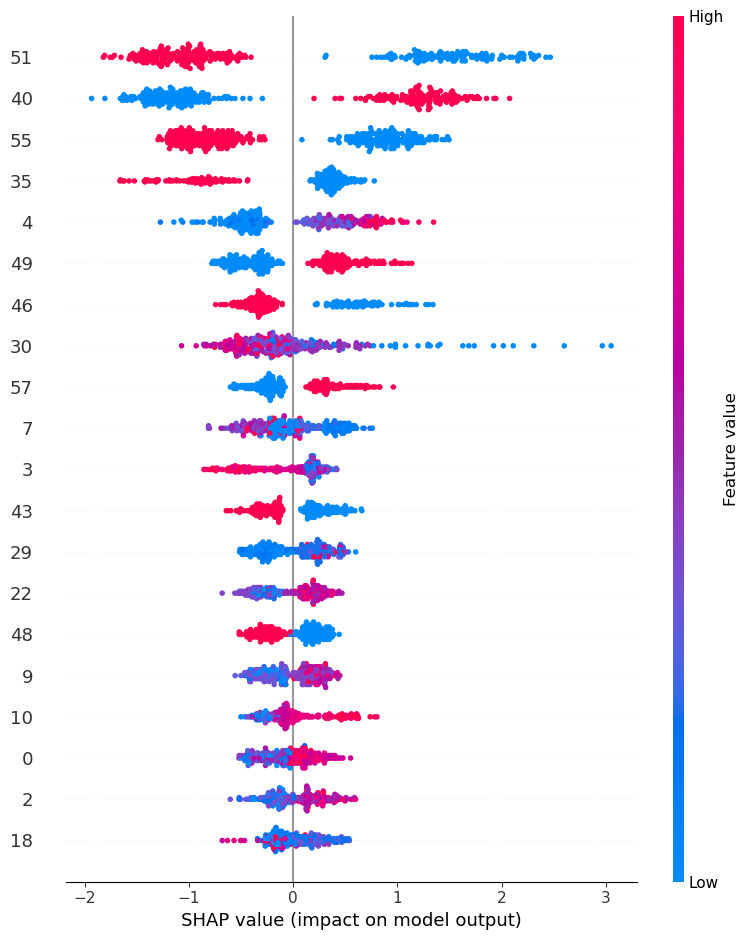

In [23]:
# compute shap values on transformed features
# If too slow, sample
Xtrans_df = pd.DataFrame(X_trans)  # column names are numeric indices; map to readable names manually if needed
shap_values = explainer.shap_values(Xtrans_df)
shap.summary_plot(shap_values, Xtrans_df)

In [24]:
# risk stratification table (example thresholds)
# use predicted probabilities
pred_probs = pipe_xgb.predict_proba(df.drop(columns=[target]))[:,1]
df['pred_prob'] = pred_probs
# thresholds (example): low <0.2, medium 0.2-0.6, high >=0.6
df['risk_bucket'] = pd.cut(df['pred_prob'], bins=[-0.01,0.2,0.6,1.0], labels=['low','medium','high'])
df.groupby('risk_bucket')[target].agg(['count','mean'])


,count,mean
risk_bucket,,
low,164,0.0
medium,0,NaN
high,139,1.0
